In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [50]:
#loading disease (response variable datasets)
df_a = pd.read_csv('asthma.csv')
df_c = pd.read_csv('copd.csv')
df_a['Value'] = df_a['Value'].str.replace('%', '', regex=False).astype(float) / 100
df_c['Value'] = df_c['Value'].str.replace('%', '', regex=False).astype(float) / 100

filter = ["State", "CountyFIPS", "County",  "Value"]

#df_d = df_d[filter]

df_c = df_c[filter]
df_a = df_a[filter]
df_a["Value Asthma"] = df_a["Value"]
df_c["Value COPD"] = df_c["Value"]


#
df_aqi = pd.read_csv("daily_aqi_by_cbsa_2024.csv")
df_pol = pd.read_csv("data_121847.csv", encoding="ISO-8859-1")



#mapping
df_map = pd.read_csv("cbsa2fipsxw.csv")
# 1) If your fips columns are floats (e.g. 1.0, 3.0, …), first convert to int:
df_map["fipsstatecode"]   = df_map["fipsstatecode"].astype(int)
df_map["fipscountycode"]  = df_map["fipscountycode"].astype(int)

# 2) Now convert to string and zero‑pad:
df_map["StateFIPS"]   = df_map["fipsstatecode"].astype(str).str.zfill(2)
df_map["CountyFIPS"]  = df_map["fipscountycode"].astype(str).str.zfill(3)

# 3) Combine into full 5‑digit FIPS:
df_map["CountyFIPS"] = df_map["StateFIPS"] + df_map["CountyFIPS"]


In [51]:
import pandas as pd

# ─── assume you've already got these in memory:
# df_a, df_map, df_aqi

# 1) Clean up df_map’s FIPS columns (as before)
df_map["fipsstatecode"]  = df_map["fipsstatecode"].astype(int)
df_map["fipscountycode"] = df_map["fipscountycode"].astype(int)
df_map["StateFIPS"]      = df_map["fipsstatecode"].astype(str).str.zfill(2)
df_map["CountyFIPS"]     = df_map["fipscountycode"].astype(str).str.zfill(3)
df_map["CountyFIPS"]     = df_map["StateFIPS"] + df_map["CountyFIPS"]

# 2) Rename the CBSA columns
df_map = df_map.rename(columns={
    "cbsacode":  "CBSA Code",
    "cbsatitle": "CBSA Title"
})

# 3) **Convert CBSA Code in df_map to a zero‑padded string**
df_map["CBSA Code"] = (
    df_map["CBSA Code"]
    .astype(int)                    # drop any .0
    .astype(str)                    # turn into strings like "10100"
    .str.zfill(5)                   # pad to 5 digits if needed
)

# 4) Make sure your county‑level FIPS is a 5‑digit string
df_a["CountyFIPS"] = df_a["CountyFIPS"].astype(str).str.zfill(5)

# 5) Merge to tag each county with its CBSA
df_cnty_cbsa = df_a.merge(
    df_map[["CountyFIPS", "CBSA Code", "CBSA Title"]],
    on="CountyFIPS", how="left"
)

# 6) Now also normalize df_aqi’s CBSA Code the same way
df_aqi["CBSA Code"] = (
    df_aqi["CBSA Code"]
    .astype(int)   # if it’s numeric, drop decimals
    .astype(str)   # to string
    .str.zfill(5)  # pad
)

# 7) Finally merge in the AQI series
df_final = df_cnty_cbsa.merge(
    df_aqi,
    on="CBSA Code",
    how="left",
    suffixes=("_county", "_aqi")
)

df_final.tail()

#df_final['Value'] = df_final['Value'].str.replace('%', '', regex=False).astype(float) / 100

,State,CountyFIPS,County,Value,Value Asthma,CBSA Code,CBSA Title,CBSA,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
292345,Wyoming,56041,Uinta,0.095,0.095,21740,"Evanston, WY-UT","Evanston, WY",2024-06-28,10.0,Good,PM10,56-041-0200,2.0
292346,Wyoming,56041,Uinta,0.095,0.095,21740,"Evanston, WY-UT","Evanston, WY",2024-06-29,12.0,Good,PM10,56-041-0201,1.0
292347,Wyoming,56041,Uinta,0.095,0.095,21740,"Evanston, WY-UT","Evanston, WY",2024-06-30,16.0,Good,PM10,56-041-0200,2.0
292348,Wyoming,56043,Washakie,0.096,0.096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292349,Wyoming,56045,Weston,0.097,0.097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
import pandas as pd

# 0) Rename the “Value” columns to distinguish asthma vs COPD
df_a = df_a.rename(columns={'Value':'Value Asthma'})
df_c = df_c.rename(columns={'Value':'Value COPD'})

# 1) Zero‑pad CountyFIPS in both
for df in (df_a, df_c):
    df['CountyFIPS'] = df['CountyFIPS'].astype(str).str.zfill(5)

# 2) Prepare your CBSA ↔ FIPS map exactly as before
df_map["fipsstatecode"]   = df_map["fipsstatecode"].astype(int)
df_map["fipscountycode"]  = df_map["fipscountycode"].astype(int)
df_map["StateFIPS"]       = df_map["fipsstatecode"].astype(str).str.zfill(2)
df_map["CountyFIPS"]      = df_map["fipscountycode"].astype(str).str.zfill(3)
df_map["CountyFIPS"]     = df_map["StateFIPS"] + df_map["CountyFIPS"]
df_map = df_map.rename(columns={
    "cbsacode":"CBSA Code",
    "cbsatitle":"Defining Parameter"  # or CBSA Title if you also want the name
})
df_map["CBSA Code"]       = df_map["CBSA Code"].astype(int).astype(str).str.zfill(5)

# 3) Normalize your AQI DF key too
df_aqi["CBSA Code"]       = df_aqi["CBSA Code"].astype(int).astype(str).str.zfill(5)

# 4) Stitch asthma & COPD together on CountyFIPS
df_cnty = (
    df_a
    .merge(df_c[['CountyFIPS','Value COPD']],
           on='CountyFIPS', how='left')
)

# 5) Tag each county with its CBSA
df_cnty_cbsa = (
    df_cnty
    .merge(df_map[['CountyFIPS','CBSA Code']],
           on='CountyFIPS', how='left')
)

# 6) Bring in only the AQI fields you care about
df_final = (
    df_cnty_cbsa
    .merge(
       df_aqi[['CBSA Code','AQI','Category','Defining Parameter']],
       on='CBSA Code', how='left'
    )
)

# 7) Keep just the five columns in the order you specified
#df_final = df_final[
#    ['AQI','Category','Defining Parameter','Value Asthma','Value COPD']
#]

df_final.tail()


,State,CountyFIPS,County,Value Asthma,Value Asthma,Value COPD,Value COPD,CBSA Code,AQI,Category,Defining Parameter
292345,Wyoming,56041,Uinta,0.095,0.095,0.064,0.064,21740,10.0,Good,PM10
292346,Wyoming,56041,Uinta,0.095,0.095,0.064,0.064,21740,12.0,Good,PM10
292347,Wyoming,56041,Uinta,0.095,0.095,0.064,0.064,21740,16.0,Good,PM10
292348,Wyoming,56043,Washakie,0.096,0.096,0.061,0.061,NaN,NaN,NaN,NaN
292349,Wyoming,56045,Weston,0.097,0.097,0.069,0.069,NaN,NaN,NaN,NaN


In [53]:
df_pol["AQI"] = df_pol["Value"]

In [54]:
import pandas as pd

# 0) assume df_final & df_pol are in memory

# 1) Clean & rename df_pol -------------------------------------------------------
df_pol2 = (
    df_pol
    # strip "Pollutant: " prefix so we get just e.g. "Benzene"
    .assign(Pollutant=lambda d: d['Pollutant']
                                   .str.replace(r'^Pollutant:\s*', '', regex=True)
                                   .str.strip(),
            CountyFIPS=lambda d: d['CountyFIPS'].astype(int).astype(str).str.zfill(5))
    .rename(columns={'AnnualValue':'AQI', 'Pollutant':'Defining Parameter'})
    .assign(Category='tbd')   # dummy category
)

# drop columns we won’t use
df_pol2 = df_pol2[['CountyFIPS','AQI','Category','Defining Parameter']]


# 2) Extract one‐row‐per‐county health lookup from df_final ------------------------
health = (
    df_final
    .loc[:, ['CountyFIPS','Value Asthma','Value COPD']]
    .drop_duplicates(subset='CountyFIPS')
)

# 3) Merge health values onto the pollutant rows --------------------------------
df_pol2 = (
    df_pol2
    .merge(health, on='CountyFIPS', how='inner')
)

# 4) (Optional) Bring along any other “metadata” you like (e.g. State, County, CBSA) -
meta = (
    df_final
    .loc[:, ['CountyFIPS','State','County','CBSA Code']]
    .drop_duplicates(subset='CountyFIPS')
)
df_pol2 = df_pol2.merge(meta, on='CountyFIPS', how='left')


# 5) Re‑order columns to match df_final (you can adapt this list to yours) --------
cols = [
    'State','CountyFIPS','County',
    'Value Asthma','Value COPD',
    'CBSA Code','AQI','Category','Defining Parameter'
]
df_pol2 = df_pol2[cols]

# 6) Finally, stack the old + new rows together
df_combined = pd.concat([df_final[cols], df_pol2], ignore_index=True, sort=False)

# 7) Inspect
print(df_combined.shape)
df_combined.head(1000000)

(316926, 11)


,State,CountyFIPS,County,Value Asthma,Value Asthma,Value COPD,Value COPD,CBSA Code,AQI,Category,Defining Parameter
0,Alabama,01001,Autauga,0.102,0.102,0.068,0.068,33860,53.00,Moderate,PM2.5
1,Alabama,01001,Autauga,0.102,0.102,0.068,0.068,33860,57.00,Moderate,PM2.5
2,Alabama,01001,Autauga,0.102,0.102,0.068,0.068,33860,55.00,Moderate,PM2.5
3,Alabama,01001,Autauga,0.102,0.102,0.068,0.068,33860,53.00,Moderate,PM2.5
4,Alabama,01001,Autauga,0.102,0.102,0.068,0.068,33860,6.00,Good,PM10
...,...,...,...,...,...,...,...,...,...,...,...
316921,Wyoming,56045,Weston,0.097,0.097,0.069,0.069,NaN,0.46,tbd,Carbon tetrachloride
316922,Wyoming,56045,Weston,0.097,0.097,0.069,0.069,NaN,0.00,tbd,"1,3-butadiene"
316923,Wyoming,56045,Weston,0.097,0.097,0.069,0.069,NaN,0.00,tbd,Napthalene
316924,Wyoming,56045,Weston,0.097,0.097,0.069,0.069,NaN,0.00,tbd,Ethylene oxide


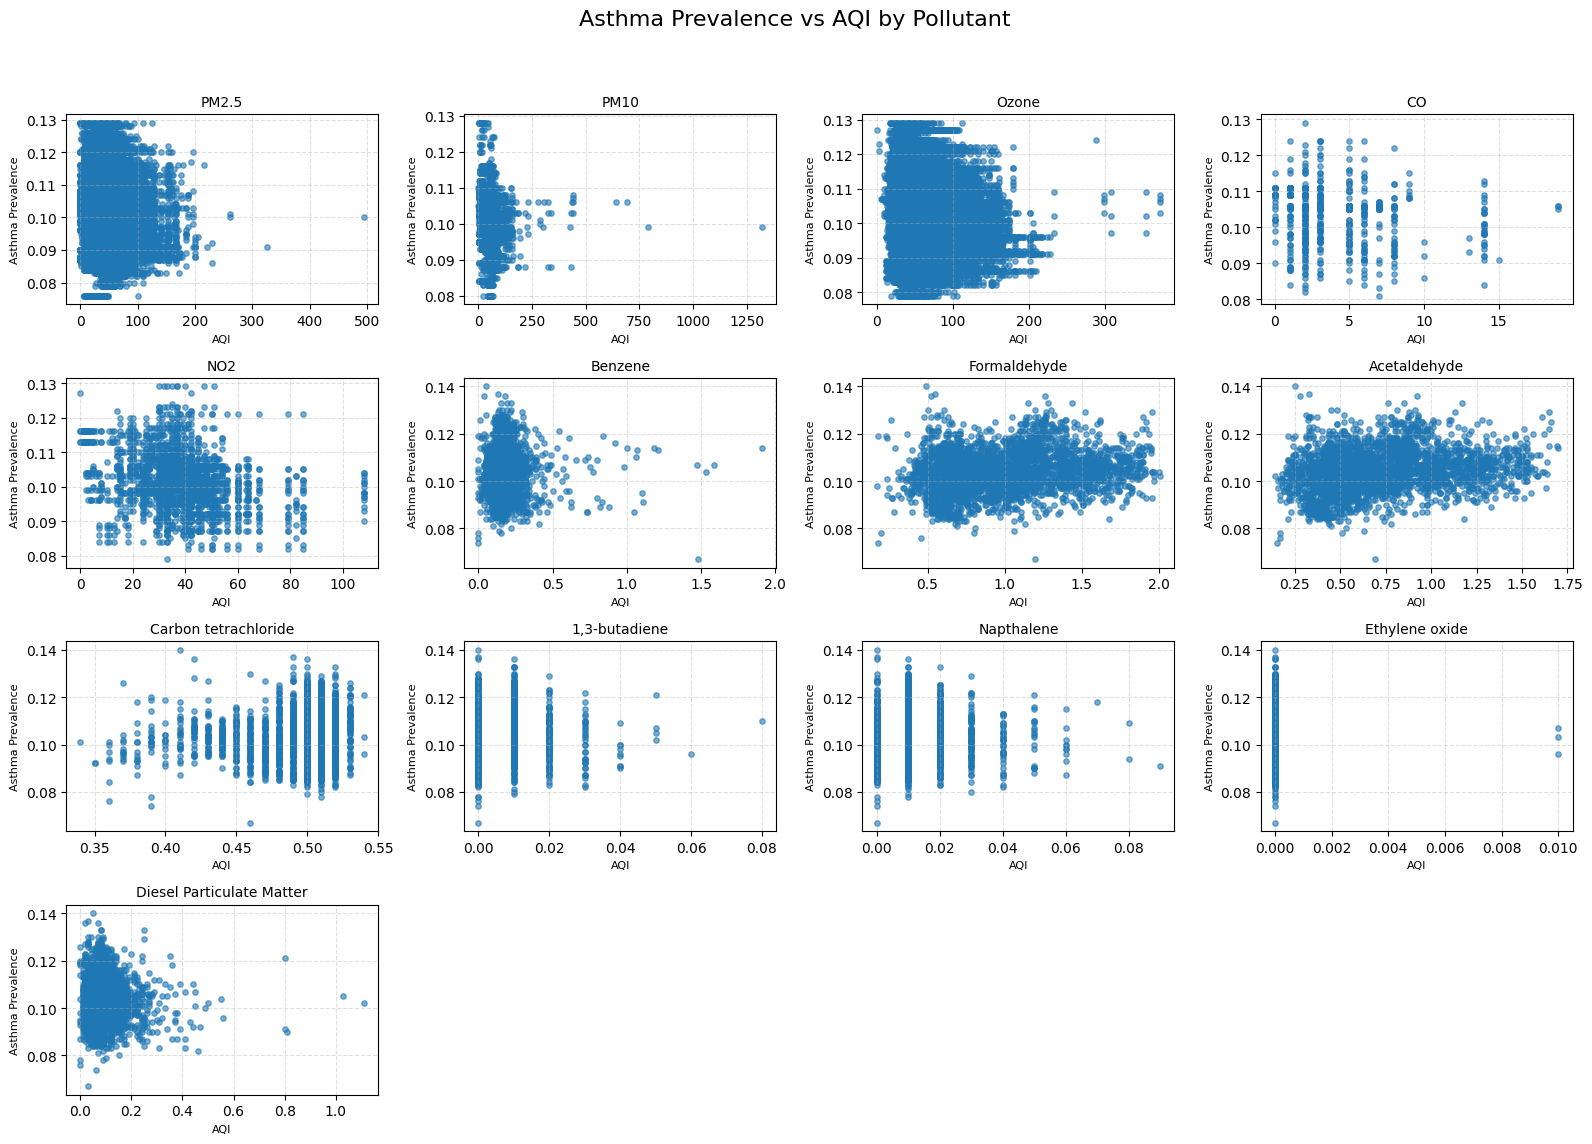

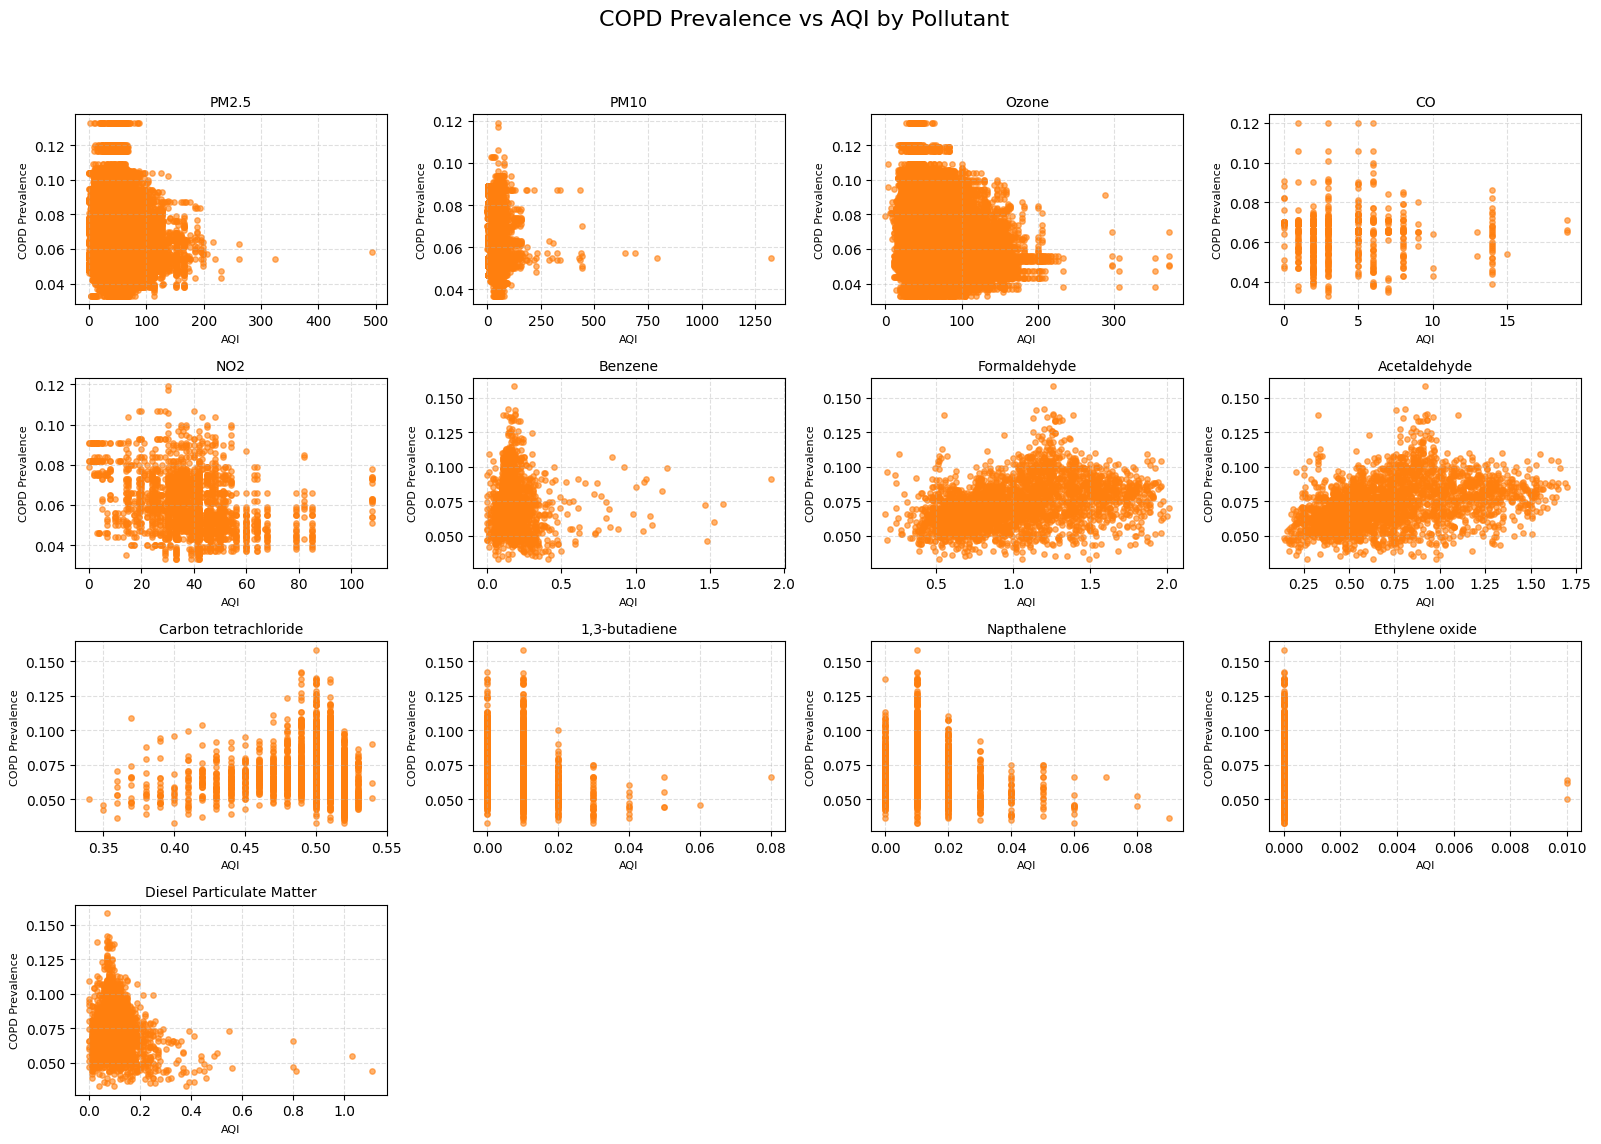

In [55]:
filter_prep = ["State", "County", "Value Asthma", "Value COPD", "AQI", "Category", "Defining Parameter"]
df_prep = df_combined[filter_prep]

import numpy as np
import matplotlib.pyplot as plt

# 0) Drop any duplicate columns so each name is unique
df_prep = df_prep.loc[:, ~df_prep.columns.duplicated()]

# 1) Get your pollutants
predictors = df_prep['Defining Parameter'].dropna().unique().tolist()

# 2) Grid configuration
n_cols = 4
n_rows = int(np.ceil(len(predictors) / n_cols))

# ─── Figure 1: Value Asthma vs. AQI ────────────────────────────────────────────
fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(16, 12))

for ax, pred in zip(axes1.flat, predictors):
    sub = df_prep[df_prep['Defining Parameter'] == pred]
    x = sub['AQI']
    y = sub['Value Asthma']
    ax.scatter(x, y, s=15, alpha=0.6)
    ax.set_title(pred, fontsize=10)
    ax.set_xlabel('AQI', fontsize=8)
    ax.set_ylabel('Asthma Prevalence', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.4)

# hide empty plots
for ax in axes1.flat[len(predictors):]:
    ax.set_visible(False)

fig1.suptitle('Asthma Prevalence vs AQI by Pollutant', fontsize=16)
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])


# ─── Figure 2: Value COPD vs. AQI ─────────────────────────────────────────────
fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(16, 12))

for ax, pred in zip(axes2.flat, predictors):
    sub = df_prep[df_prep['Defining Parameter'] == pred]
    x = sub['AQI']
    y = sub['Value COPD']
    ax.scatter(x, y, s=15, alpha=0.6, color='tab:orange')
    ax.set_title(pred, fontsize=10)
    ax.set_xlabel('AQI', fontsize=8)
    ax.set_ylabel('COPD Prevalence', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.4)

for ax in axes2.flat[len(predictors):]:
    ax.set_visible(False)

fig2.suptitle('COPD Prevalence vs AQI by Pollutant', fontsize=16)
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


In [56]:
import pandas as pd

# 0) (Re)load or ensure df_prep is in memory here

# 1) Drop any duplicate columns so each name is unique
df_prep = df_prep.loc[:, ~df_prep.columns.duplicated()]

# 2) Define EPA threshold values for the criteria pollutants
#thresholds = {
#    'PM2.5': 8,      # µg/m³ annual
#    'PM10': 100,      # µg/m³ 24‑hr
#    'Ozone': 0.02,    # ppm 8‑hr
#    'CO': 4,          # ppm 8‑hr
#    'NO2': 32         # ppb annual
#}

thresholds = {
    # Your custom “good” cutoffs for criteria pollutants
    'PM2.5': 8,        # µg/m³ annual
    'PM10': 100,       # µg/m³ 24‑hr
    'Ozone': 0.02,     # ppm 8‑hr
    'CO': 4,           # ppm 8‑hr
    'NO2': 32,         # ppb annual

    # EPA IRIS Reference Concentrations (RfC) for air toxics (mg/m³)
    'Benzene':                0.03,      # RfC = 3×10⁻² mg/m³ :contentReference[oaicite:0]{index=0}
    'Formaldehyde':           0.8,     # RfC = 8×10⁻³ mg/m³ :contentReference[oaicite:1]{index=1}
    'Acetaldehyde':           0.9,     # RfC = 9×10⁻³ mg/m³ :contentReference[oaicite:2]{index=2}
    'Carbon tetrachloride':   0.1,       # RfC = 1×10⁻¹ mg/m³ :contentReference[oaicite:3]{index=3}
    '1,3-butadiene':          0.007,     # RfC ≈ 7×10⁻³ mg/m³ :contentReference[oaicite:4]{index=4}
    'Napthalene':             0.005,     # RfC = 5×10⁻³ mg/m³ :contentReference[oaicite:5]{index=5}
    'Ethylene oxide':         0.0001,    # RfC = 1×10⁻⁴ mg/m³ :contentReference[oaicite:6]{index=6}

    # Diesel PM (from 2002 National‑Scale Assessment; 5 µg/m³ → 0.005 mg/m³)
    'Diesel Particulate Matter': 0.05  # RfC = 5 µg/m³ = 5×10⁻³ mg/m³ :contentReference[oaicite:7]{index=7}
}

# 3) Make sure you have a Category column
if 'Category' not in df_prep.columns:
    df_prep['Category'] = pd.NA

# 4) Assign Good/High based on thresholds
for pollutant, thr in thresholds.items():
    mask = df_prep['Defining Parameter'] == pollutant
    df_prep.loc[mask & (df_prep['AQI'] <= thr), 'Category'] = 'Good'
    df_prep.loc[mask & (df_prep['AQI']  > thr), 'Category'] = 'High'

# 5) Give everything else a placeholder if you like
df_prep['Category'] = df_prep['Category'].fillna('tbd')

# 6) Check your work
print(df_prep[['Defining Parameter','AQI','Category']].drop_duplicates().sort_values('Defining Parameter'))


       Defining Parameter     AQI Category
294418      1,3-butadiene    0.06     High
294890      1,3-butadiene    0.05     High
292354      1,3-butadiene    0.01     High
292906      1,3-butadiene    0.02     High
315034      1,3-butadiene    0.08     High
...                   ...     ...      ...
5067                PM2.5  220.00     High
183401              PM2.5  118.00     High
5100                PM2.5  104.00     High
0                   PM2.5   53.00     High
415                   NaN     NaN      tbd

[1060 rows x 3 columns]


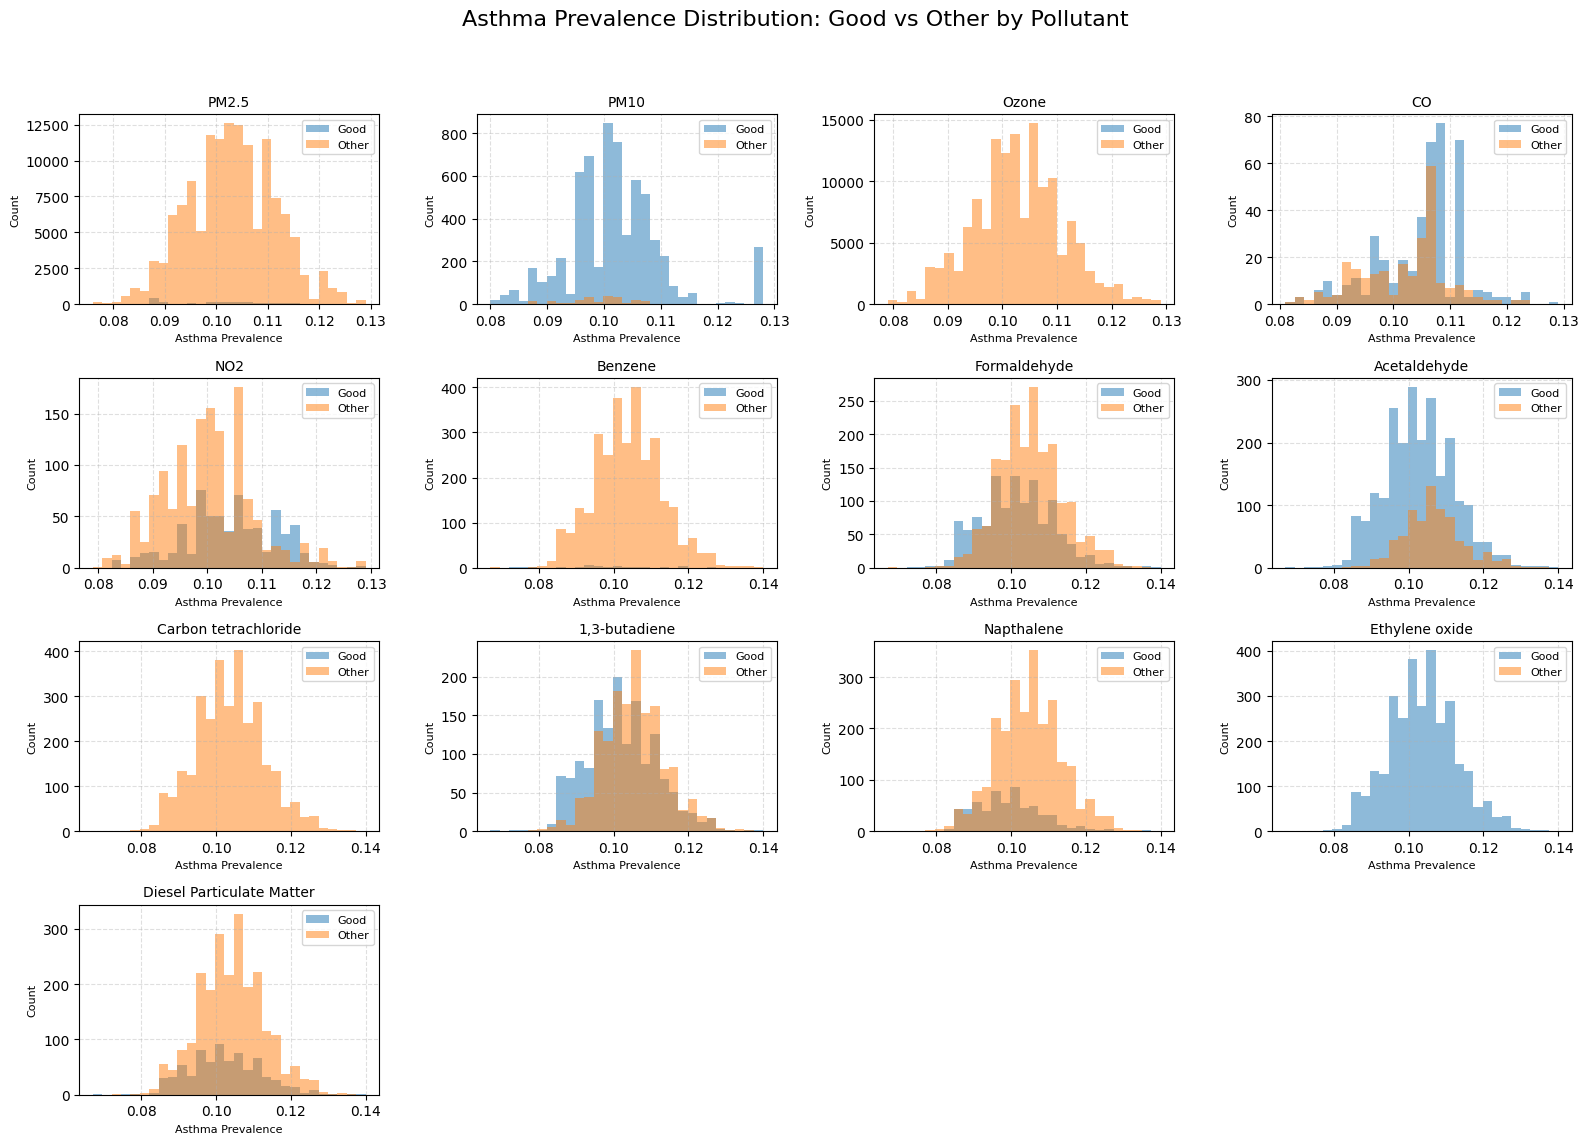

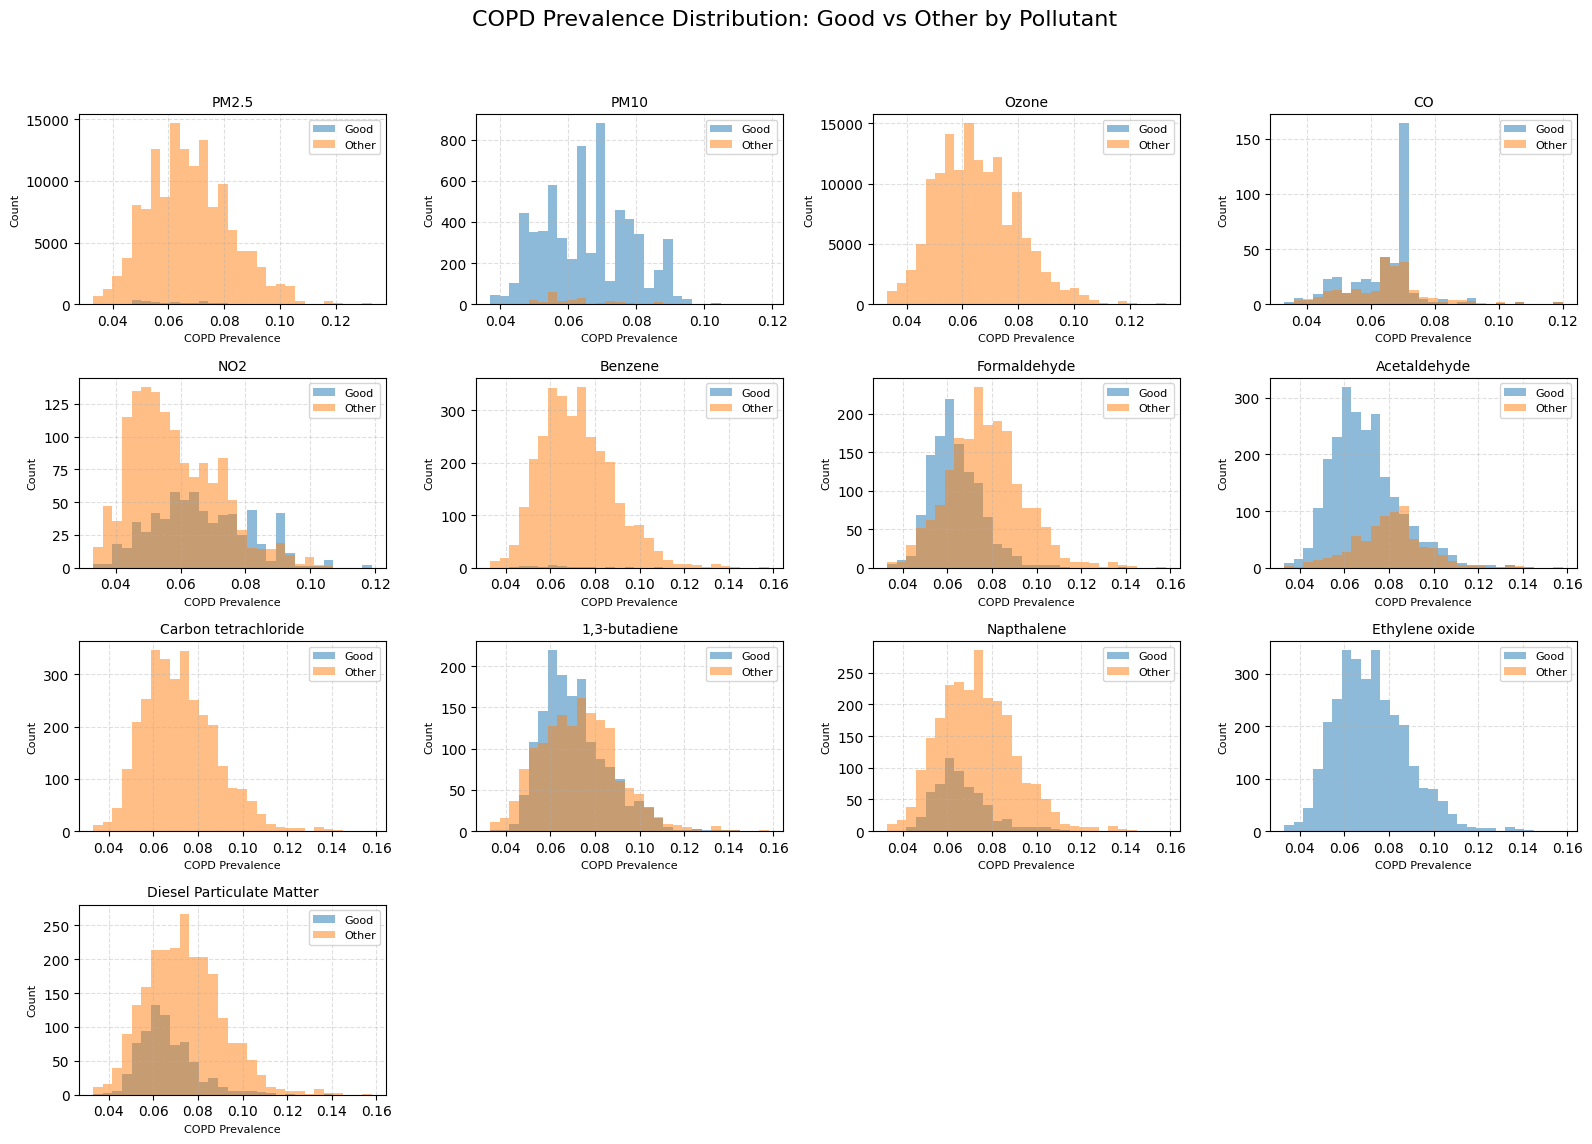

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Deduplicate columns
df_prep = df_prep.loc[:, ~df_prep.columns.duplicated()]

# List of pollutants
predictors = df_prep['Defining Parameter'].dropna().unique().tolist()

# Grid layout
n_cols = 4
n_rows = int(np.ceil(len(predictors) / n_cols))

# ––– Histograms of Asthma prevalence –––
fig_a, axes_a = plt.subplots(n_rows, n_cols, figsize=(16, 12), sharex=False, sharey=False)
for ax, pred in zip(axes_a.flat, predictors):
    sub = df_prep[df_prep['Defining Parameter']==pred].dropna(subset=['Value Asthma','Category'])
    if sub.empty:
        ax.set_visible(False)
        continue
    good = sub[sub['Category']=='Good']['Value Asthma']
    other = sub[sub['Category']!='Good']['Value Asthma']
    bins = np.linspace(sub['Value Asthma'].min(), sub['Value Asthma'].max(), 30)
    ax.hist(good,  bins=bins, histtype='stepfilled', alpha=0.5, label='Good')
    ax.hist(other, bins=bins, histtype='stepfilled', alpha=0.5, label='Other')
    ax.set_title(pred, fontsize=10)
    ax.set_xlabel('Asthma Prevalence', fontsize=8)
    ax.set_ylabel('Count', fontsize=8)
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.4)
for ax in axes_a.flat[len(predictors):]:
    ax.set_visible(False)
fig_a.suptitle('Asthma Prevalence Distribution: Good vs Other by Pollutant', fontsize=16)
fig_a.tight_layout(rect=[0,0.03,1,0.95])


# ––– Histograms of COPD prevalence –––
fig_c, axes_c = plt.subplots(n_rows, n_cols, figsize=(16, 12), sharex=False, sharey=False)
for ax, pred in zip(axes_c.flat, predictors):
    sub = df_prep[df_prep['Defining Parameter']==pred].dropna(subset=['Value COPD','Category'])
    if sub.empty:
        ax.set_visible(False)
        continue
    good = sub[sub['Category']=='Good']['Value COPD']
    other = sub[sub['Category']!='Good']['Value COPD']
    bins = np.linspace(sub['Value COPD'].min(), sub['Value COPD'].max(), 30)
    ax.hist(good,  bins=bins, histtype='stepfilled', alpha=0.5, label='Good')
    ax.hist(other, bins=bins, histtype='stepfilled', alpha=0.5, label='Other')
    ax.set_title(pred, fontsize=10)
    ax.set_xlabel('COPD Prevalence', fontsize=8)
    ax.set_ylabel('Count', fontsize=8)
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.4)
for ax in axes_c.flat[len(predictors):]:
    ax.set_visible(False)
fig_c.suptitle('COPD Prevalence Distribution: Good vs Other by Pollutant', fontsize=16)
fig_c.tight_layout(rect=[0,0.03,1,0.95])

plt.show()



In [63]:
df = df_prep

# Using a Random Forest to identify most important predictors


=== Value Asthma Model ===
              precision    recall  f1-score   support

    Low-Risk       0.76      0.79      0.78       497
   High-Risk       0.74      0.71      0.73       425

    accuracy                           0.75       922
   macro avg       0.75      0.75      0.75       922
weighted avg       0.75      0.75      0.75       922



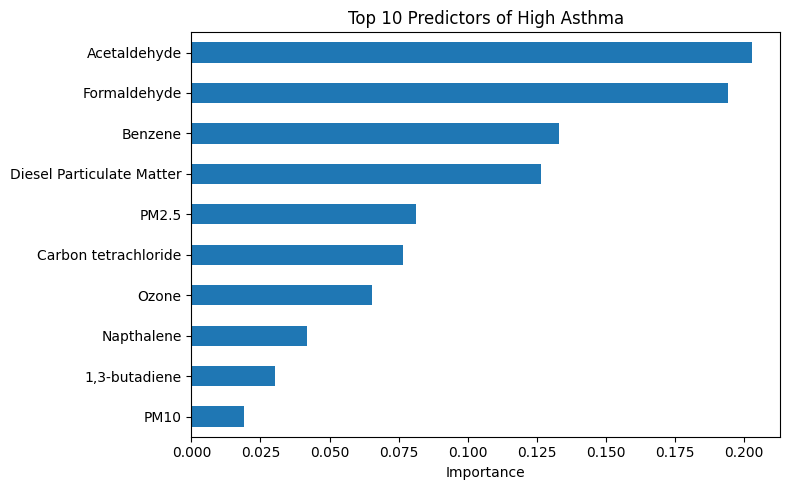


=== Value COPD Model ===
              precision    recall  f1-score   support

    Low-Risk       0.79      0.83      0.81       468
   High-Risk       0.81      0.77      0.79       454

    accuracy                           0.80       922
   macro avg       0.80      0.80      0.80       922
weighted avg       0.80      0.80      0.80       922



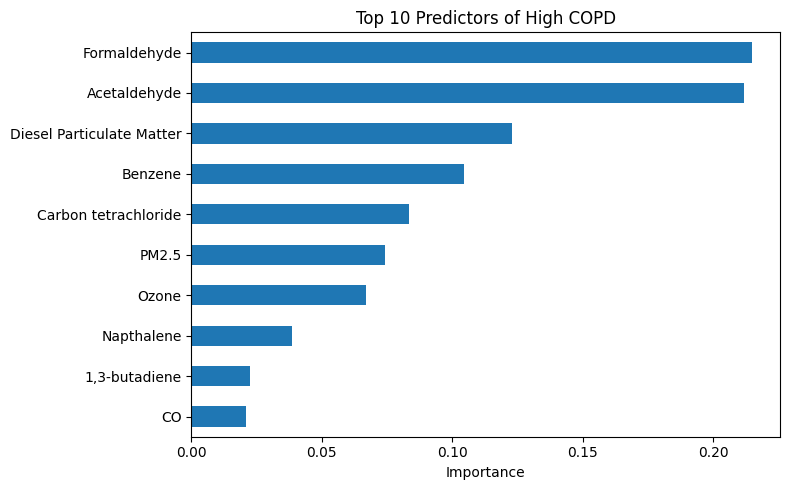

In [59]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 0) Deduplicate any columns, just in case
df_prep = df_prep.loc[:, ~df_prep.columns.duplicated()]

# 1) Pivot to wide: one row per region, columns = pollutant AQIs
df_wide = (
    df_prep
    .pivot_table(
        index=['State','County'],
        columns='Defining Parameter',
        values='AQI',
        aggfunc='mean'
    )
    .reset_index()
)

# 2) Pull in the health targets (one row per region)
df_health = (
    df_prep[['State','County','Value Asthma','Value COPD']]
    .drop_duplicates(subset=['State','County'])
)
df_ml = df_wide.merge(df_health, on=['State','County'], how='inner')

# 3) Define a helper to train & report RF model
def run_rf(target_col, df):
    # binarize: high‑risk if > median
    y = (df[target_col] > df[target_col].median()).astype(int)
    X = df.drop(columns=['State','County','Value Asthma','Value COPD'])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    rf = RandomForestClassifier(
        n_estimators=200, class_weight='balanced', random_state=42
    )
    rf.fit(X_train, y_train)

    # Print performance
    print(f"\n=== {target_col} Model ===")
    y_pred = rf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['Low-Risk','High-Risk']))

    # Feature importances
    imps = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    top10 = imps.head(10)

    # Plot
    plt.figure(figsize=(8,5))
    top10.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f"Top 10 Predictors of High {target_col.replace('Value ','')}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    return imps

# 4) Run for asthma and COPD
imps_asthma = run_rf('Value Asthma', df_ml)
imps_copd   = run_rf('Value COPD',   df_ml)


In [73]:
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def run_rf(target_col, df):
    # binarize: high‑risk if > median
    y = (df[target_col] > df[target_col].median()).astype(int)
    X = df.drop(columns=['State','County','Value Asthma','Value COPD'])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    rf = RandomForestClassifier(
        n_estimators=200, class_weight='balanced', random_state=42
    )
    rf.fit(X_train, y_train)

    # Predictions
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]  # for ROC AUC

    # === Evaluation ===
    print(f"\n=== {target_col} Model ===")
    print(classification_report(y_test, y_pred, target_names=['Low-Risk','High-Risk']))
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {auc:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low-Risk','High-Risk'])
    disp.plot(cmap="Blues")
    plt.title(f"{target_col} – Confusion Matrix")
    plt.show()

    # === Feature Importances ===
    imps = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    top10 = imps.head(10)

    plt.figure(figsize=(8,5))
    top10.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f"Top 10 Predictors of High {target_col.replace('Value ','')}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    return imps



=== Value Asthma Model ===
              precision    recall  f1-score   support

    Low-Risk       0.76      0.79      0.78       497
   High-Risk       0.74      0.71      0.73       425

    accuracy                           0.75       922
   macro avg       0.75      0.75      0.75       922
weighted avg       0.75      0.75      0.75       922

ROC AUC: 0.826


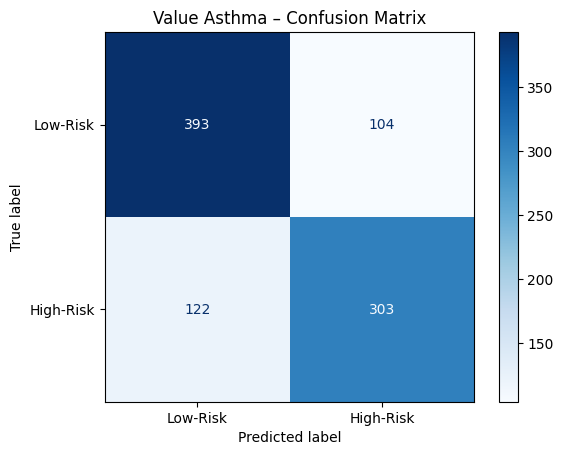

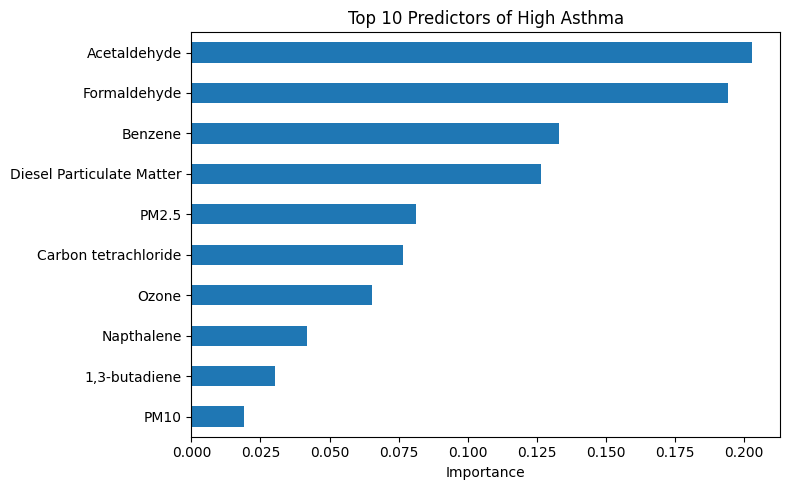


=== Value COPD Model ===
              precision    recall  f1-score   support

    Low-Risk       0.79      0.83      0.81       468
   High-Risk       0.81      0.77      0.79       454

    accuracy                           0.80       922
   macro avg       0.80      0.80      0.80       922
weighted avg       0.80      0.80      0.80       922

ROC AUC: 0.874


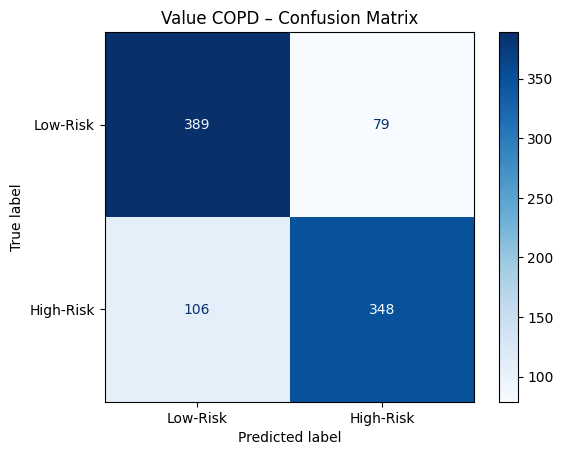

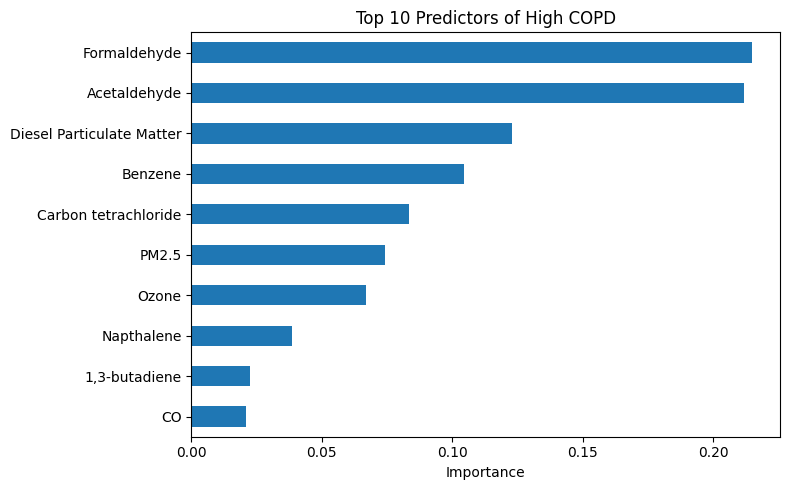

In [74]:
imps_asthma = run_rf('Value Asthma', df_ml)
imps_copd   = run_rf('Value COPD', df_ml)


In [67]:
# Get min and max for later rescaling

asthma_min = df['Value Asthma'].min()
asthma_max = df['Value Asthma'].max()
copd_min = df['Value COPD'].min()
copd_max = df['Value COPD'].max()

# Normalize
df['Value Asthma Scaled'] = (df['Value Asthma'] - asthma_min) / (asthma_max - asthma_min)
df['Value COPD Scaled'] = (df['Value COPD'] - copd_min) / (copd_max - copd_min)


top_predictors = [
    'Formaldehyde', 'Acetaldehyde', 'Diesel Particulate Matter', 'Benzene',
    'Carbon tetrachloride', 'PM2.5', 'Ozone', 'Napthalene'
]

df_wide = df.pivot_table(
    index=['State', 'County'],
    columns='Defining Parameter',
    values='AQI',
    aggfunc='mean'
).reset_index()

# Merge target values back in
target_df = df[['State', 'County', 'Value Asthma Scaled', 'Value COPD Scaled']].drop_duplicates()
df_wide = df_wide.merge(target_df, on=['State', 'County'], how='left')

X = df_wide[top_predictors]
y_asthma = df_wide['Value Asthma Scaled']
y_copd = df_wide['Value COPD Scaled']


In [69]:
from sklearn.impute import SimpleImputer

# Impute missing values with column mean (or median)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Then continue with train-test split etc.
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_asthma, test_size=0.2, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Sigmoid + rescale
from scipy.special import expit
y_pred_scaled = expit(linreg.predict(X_test))
y_pred = y_pred_scaled * (asthma_max - asthma_min) + asthma_min


In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# True values in original scale
y_true = y_test * (asthma_max - asthma_min) + asthma_min

# 1. MSE and R²
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.0002
R² Score: -0.9477


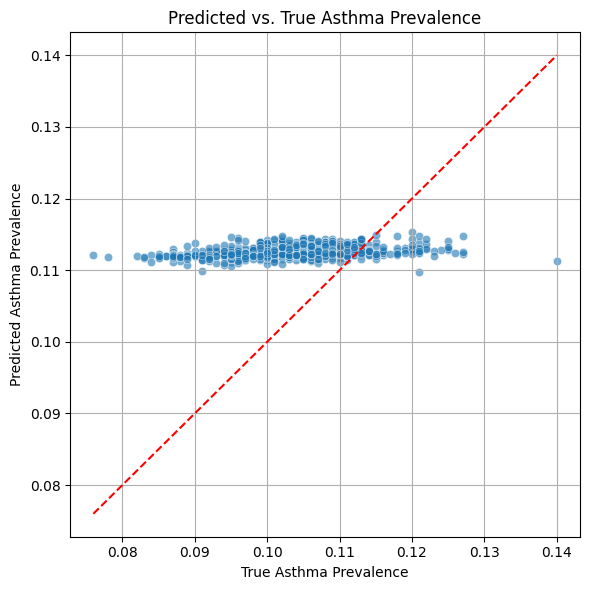

In [71]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # identity line
plt.xlabel("True Asthma Prevalence")
plt.ylabel("Predicted Asthma Prevalence")
plt.title("Predicted vs. True Asthma Prevalence")
plt.grid(True)
plt.tight_layout()
plt.show()


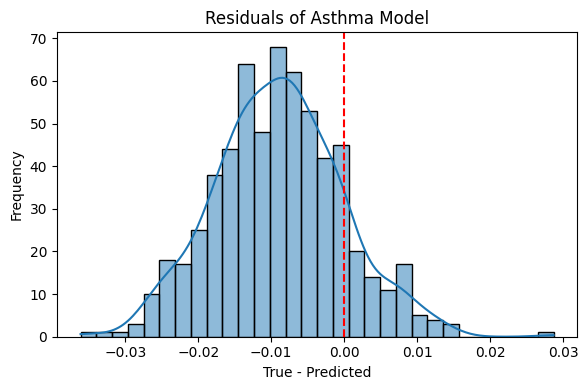

In [72]:
residuals = y_true - y_pred

plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals of Asthma Model")
plt.xlabel("True - Predicted")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
